In [1]:
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
'''
Resnet 또한 Google Net과 같이 Block들을 모아서 하나로 합쳐야함
'''

'\nResnet 또한 Google Net과 같이 Block들을 모아서 하나로 합쳐야함\n'

In [3]:
#이미지 표현을 위한 라이브러리

import numpy as np

from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
import os

image_path='C:/Users/kwonc/Desktop/ResNet'

In [5]:
os.listdir(image_path)

['ResNet구조.PNG']

In [6]:
image_data=image_path+'/'+os.listdir(image_path)[0]
image_data

'C:/Users/kwonc/Desktop/ResNet/ResNet구조.PNG'

In [7]:
#이미지 열기+시각화
image=Image.open(image_data)
print(image.size)

(671, 288)


In [8]:
image=np.array(image)

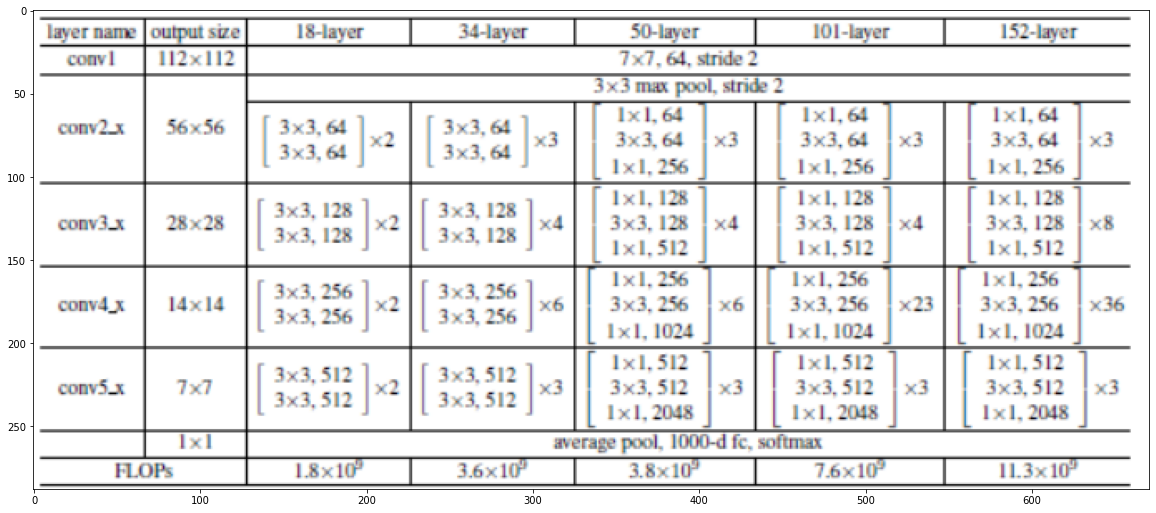

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.show()

In [10]:
#######ResNet 구조

In [11]:
# conv1 class 정의
# 위에 사진에서 정의하는 Conv1->Max pool 과정 정의

class conv1(nn.Module):
    def __init__(self,input_channels=3,out_channels=64):
        super(conv1,self).__init__()
        self.conv1=nn.Conv2d(input_channels,out_channels,kernel_size=7,stride=2,padding=3,bias=False) #batch normalization에 bias포함 이기 때문에, bias=False, output size=(224-7+2*3)/2+1
        self.batchnorm1=nn.BatchNorm2d(out_channels)
        self.relu1=nn.ReLU()
        self.maxpool1=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
    def forward(self,x):
        #conv->batch norm->activation
        x=self.relu1(self.batchnorm1(self.conv1(x)))
        #max pooling
        x=self.maxpool1(x)
        return x
     
        
conv1=conv1()

In [12]:
### 1x1 convolution 층, 3x3 convolution 층 define->basic block, Bottle neck에서 활용가능

def conv1x1(in_channel, out_channel, kernel_size=1, stride=1, bias=False): #차원축소, 다시 차원 늘려주는 용도의 Convolutio 1x1 layer
    '''
    1x1 convolution in Basic Block
    in_channel=64,256,512,1024(152 layer)
    out_channel=128,256,512,1024,2048
    bias=False->batch norm에서 bias가 포함됨
    '''
    return nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=1, bias=False)


def conv3x3(in_channel, out_channel, kernel_size=3, stride=1, bias=False):
    return nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, bias=False)

In [13]:
### Basic Block, Bottleneck define

In [14]:
#Basic Block
#Basic Block structure=input->3x3 convolution-> batch norm-> activation ->3x3 convolution-> batch norm
#Resnet 이전의 방식
#Resnet 50층 미만일 경우에는 BasicBlock 사용
#3x3 두개로 구성


class BasicBlock(nn.Module): #계층의 묶음 Basic Block은 기존의 방식임
    expansion=1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function=nn.Sequetial(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels*BasicBlock.expansion,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BacthcNorm2d(out_channels*BasicBlcok.expansion),
        )
        
        #idnetity mapping=숏컷매핑함수=skip connection=H(x)=F(x)+x 형태=identity mapping이란 입력 x가 어떤 함수를 통과하더라도 다시 x라는 형태로 출력되도록 하는 것.
        #identity mapping은 input과 output의 feature map size, filter수가 동일한 경우 사용 가능함.
        self.shortcut=nn.Sequential()
        self.relu=nn.ReLU()
        
        #projection mapping using 1x1 conv, projection mapping은 입력의 차원을 출력에 맞추어 변경하는 것
        if stride != 1 or in_channels != BasicBlock.expansion*out_channels:
            self.shortcyt=nn.Sequential(
                nn.Conv2d(in_channels,out_channels*BasicBlock.expansion,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels*BasicBlock.expansion)
            )
            
    def forward(self,x):
        x=self.residual_function(x)+self.shortcut(x) #F(x)+x 형태 즉 identity mapping 입력값 형태=출력값 형태로 만들어줌
        x=self.relu(x)
        return x
        
            
        

In [15]:
# Bottle Neck define(ResNet50, ResNet101, ResNet152)

In [16]:
#Bottle neck block은 1x1, 3x3, 1x1 합성곱층으로 구성됨
#projection mapping 사용-> input과 output형태 맞춰 주기 위하여 shortcut사용

class Bottleneck(nn.Module):
    expansion=4 #병목 블록에서는 블록의 마지막 아웃풋 채널이 input channel의 4배이기 때문에 expansion 파라미터를 정의해줌
    def __init__(self,in_channels,out_channels,stride=1):
        super().__init__()
        
        
        self.residual_function=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False), #이후에 stride값 따로 지정해주어 이미지 사이즈 변환을 위해 stride=stride로 설정
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels*Bottleneck.expansion,kernel_size=1,stride=1,bias=False),
            nn.BatchNorm2d(out_channels*Bottleneck.expansion),
        )
        
        #identity mapping
        
        self.shortcut=nn.Sequential()
        
        self.relu = nn.ReLU()
        
        if stride != 1 or in_channels != out_channel*Bottleneck.expansion:
            self.shortcut=nn.Sequential(
                nn.Conv2d(in_channels, out_channels*Bottleneck.expansion,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels*Bottleneck.expansion)
            )
            
        def forward(self,x):
            x=self.residual_function(x)+self.shortcut(x)
            x=self.relu(x)
            return x

In [17]:
# Resnet model Network

In [18]:
'''
        # resnet18
        # ResNet(BasicBlock, [2,2,2,2])
        # resnet34
        # ResNet(BasicBlock, [3, 4, 6, 3])
        # resnet50
        # ResNet(BottleNeck, [3,4,6,3])
        # resnet101
        # ResNet(BottleNeck, [3, 4, 23, 3])
        # resnet152
        # ResNet(BottleNeck, [3, 8, 36, 3])
        
'''

'\n        # resnet18\n        # ResNet(BasicBlock, [2,2,2,2])\n        # resnet34\n        # ResNet(BasicBlock, [3, 4, 6, 3])\n        # resnet50\n        # ResNet(BottleNeck, [3,4,6,3])\n        # resnet101\n        # ResNet(BottleNeck, [3, 4, 23, 3])\n        # resnet152\n        # ResNet(BottleNeck, [3, 8, 36, 3])\n        \n'

In [26]:
class ResNet(nn.Module):
    def __init__(self,block,num_block,num_classes=3,init_weights=True): #ResNet block-> block은 basic인지 Bottle neck인지, num_block은 각 Residual block 몇번 반복할지 list형태, num_class는 분류한 클래스 개수
        super().__init__()
        
        self.in_channels=64 #첫번째 block에 들어갈 채널값이 64이기 때문에 여기서부터 설정해줌
        
        self.conv_1=conv1(input_channels=3,out_channels=64) #kernel size=7, stride=2, padding=3, bias=False ->module 위에 의미 설정되어있음 conv->batch->activation->maxpool
        
        #Residual block
        self.conv2_x=self.make_layer(block,64,num_block[0],1) # 18layer=2번 반복, 18layer이상은 3번 반복
        self.conv3_x=self.make_layer(block,128,num_blcok[1],2) #make_layer(block, out channel, num block, stride)->파라미터 입력시켜줌
        self.conv4_x=self.make_layer(block,256,num_blcok[2],2)
        self.conv5_x=self.make_layer(block,512,num_blcok[3],2)
        
        #avg pooling define
        self.avg_pool=nn.AdaptiveAvgPool2d((1,1)) #AdaptiveAvgPool2d 1x1사이즈로 ->2048개 출력
        self.fc=nn.Linear(512*block.expansion,num_classes)
        
        #weights 초기화->weights 초기화를 통하여 그라디언트 소실/폭발 문제 피함.
        if init_weights:
            self._initialize_weights() #밑에서 _initialize 따로 정의 True일시에 각 층에 가중치들 초기화 진행해줌.
            
    def make_layer(self, block, out_channels, num_blocks, stride): #make layer를 통해
        stride=[stride]+[1]*(num_blocks-1)
        layers=[]
        for stride in strides:
            layers.append(block(self.in_channels,out_channels,stride))
            self.in_channels=out_channels * block.expansion #64였던 channel에 expansion 곱해주어 이후에 input과 output channel depth 맞춰줌,self.modules()-> 모델 클래스에서 정의된 layer들을 iterable로 차례로 반환
            
        return nn.Sequential(*layers)
    
    def forward(self,x):
        output=self.conv_1(x) #224x224x3->convolution->batchnorm->Relu->maxpooling->112x112x64
        output=self.conv2_x(output) #112x112x64->conv 1x1->batch->Relu-> conv 3x3->batch ->Relu->conv 1x1 ->batch ->56x56x256 -> 이 과정을 3번 반복함.
        x=self.conv3_x(output) #56x56x256->28x28x512
        x=self.conv4_x(x) #28x28x512
        x=self.conv5_x(x) #14x14x1024
        x=self.avg_pool(x) #7x7x2048
        x=view(x,size(0),-1) #2048 nodes 배치사이즈 제외->flatten
        x=self.fc(x) #fully connected layer
        return x
        
    #define weight 초기화 부분
    def _initialize_weights(self): #가중치 초기화->성능이 높아짐->초기화 방법을 적용한 모델이 다른 모델에 비해 학습 속도와 에러가 모두 낮음을 알 수 있음
        for m in self.modules():
            if isinstance(m,nn.Conv2d): #module 의 method중 Convolution층에 해당하는 부분이 있는지 확인해주는 함수
                nn.init.kaiming_normal_(m,weight,mode='fan_out', nonlinearity='relu') #kaming HE 초기화->역방퍙으로 크기 유지하면서 초기화->정규분포로 m.weight초기화->layer에 맞춰서 초기화해줌
                if m.bias is not None:
                    nn.init.constant(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d): #batch normalization initailize
                nn.init.constant_(m.weight,1) #m.weight를 1로 바꾸어줌
                nn.init.constant_(m.bias,0) #m.bias를 0으로 바꾸어줌
            elif isinstance(m.nn.Linear): #fully initialize
                nn.init.normal_(m.weight,0,0.01) #weight~N(0,0.01)
                nn.init.constant_(m.bias,0) #bias를 0으로 변환
                        

                        

        

In [20]:
#w = torch.empty(3, 5)
#print(w)
#nn.init.constant_(w, 0.3)
#print(w)

tensor([[9.2755e-39, 1.0561e-38, 9.8265e-39, 1.0194e-38, 9.0919e-39],
        [4.2246e-39, 1.0286e-38, 1.0653e-38, 1.0194e-38, 8.4490e-39],
        [1.0469e-38, 9.3674e-39, 9.9184e-39, 8.7245e-39, 9.2755e-39]])
tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000]])


In [22]:
#w = torch.empty(3, 5)
#print(w)
#nn.init.kaiming_normal_(w, mode='fan_out', nonlinearity='relu')

tensor([[9.9184e-39, 8.7245e-39, 9.2755e-39, 8.9082e-39, 9.9184e-39],
        [8.4490e-39, 9.6429e-39, 1.0653e-38, 1.0469e-38, 4.2246e-39],
        [1.0378e-38, 9.6429e-39, 9.2755e-39, 9.7346e-39, 1.0745e-38]])


tensor([[ 0.7827, -1.4511, -1.6624,  1.0133, -0.9822],
        [ 0.1804, -0.4029, -1.0466,  0.4944,  0.0227],
        [-0.5933,  0.2253,  0.1049, -0.3710, -0.2095]])

In [41]:
a=int(min(np.ceil(15*0.1),10))

In [42]:
a.double()

AttributeError: 'int' object has no attribute 'double'

In [40]:
for phase in ['train','val']:
    print(phase)
              

train
val


In [49]:
class ResNetModel(nn.Module):
    def __init__(self,train_dataset,val_dataset,num_classes,epoch,learning_rate,batch_size,loader_num_workers,init_weights,num_block):
        self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu') #gpu 사용
        self.train_dataset=train_dataset #train set
        self.val_dataset=val_dataset # validation set
        self.num_classes=num_classes # 분류한 class개수
        self.epoch=epoch #빈복횟수
        self.learning_rate=learning_rate #학습률
        self.batch_size=batch_size #미니배치 사이즈
        self.loader_num_workers=loader_num_workers #코어 개수
        self.num_block=num_block #층마다 다름 층에 맞게 리스트화
        self.patience_i=int(min(np.ceil(epoch*0.1),10)) #learning rate scheduler parameter로 사용 patience: metric이 향상 안될 때, 몇 epoch을 참을 것인가?
        
    def ResNetTrain(self):
        # resnet18
        # ResNet(BasicBlock, [2,2,2,2])
        # resnet34
        # ResNet(BasicBlock, [3, 4, 6, 3])
        # resnet50
        # ResNet(BottleNeck, [3,4,6,3])
        # resnet101
        # ResNet(BottleNeck, [3, 4, 23, 3])
        # resnet152
        # ResNet(BottleNeck, [3, 8, 36, 3])
        #module ResNet(block,num_block,num_classes=3,init_weights=True)
        
        
        model=ResNet(Bottleneck,num_block=self.num_block,num_classes=self.num_classes,init_weights=True).to(self.device)
        
        criterion=nn.CrossEntropyLoss() #다중분류
        optimizer=optim.Adam(model.parameters(),lr=self.learning_rate,weight_decay=1e-4) #weight decay->과적합 방지를 위해 가중치 감소 너무 큰값을 가지지 않도록 해줌.
        lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=self.patience_i,verbose=True) #학습과정에서 learning rate를 조절 가능, verbose=True->표준출력 True
        #learning rate scheduler를 사용하면 처음엔 큰 보폭으로 빠르게 최적값에 가까워지도록 하다가 이후에는 learning rate를 줄여 미세조정함.
        #ReduceLROnPlateau lr scheduler는 모델의 성능이 향상되지 않을 시에 lr을 감소시킨다.
        
        train_loader=DataLoader(self.train_dataset,batch_size=self.batch_size,shuffle=True, num_workers=self.loader_num_workers) # train data Loader
        val_loader=DataLoader(self.train_dataset,batch_size=self.batch_size,shuffle=True, num_workers=self.loader_num_workers) #validation data Loader
        dataloaders={'train':train_loader, 'val':val_loader}
        
        since=time.time() #시작시간
        train_acc_history=[] #train accuracy 기록 리스트
        train_loss_history=[] #train loss 기록 리스트
        val_acc_history=[] #validation accuracy 기록 리스트
        val_loss_history=[] #validation loss 기록 리스트
        best_models_wts=copy.deepcopy(model.state_dict()) #deepcopy->내부 객체들 모두 새롭게 copy
        best_acc=0.0
        use_auxiliary=False #google net 에서 사용함
        
        for i in range(self.epoch):
            epoch_time=time.time()
            print('Epoch {}/{}'.format(i+1,self.epoch))
            print('-'*10)
            
            for phase in ['train','val']: #phase= 'train', 'val'
                if phase =='train':
                    model.train() #model training mode
                else:
                    model.eval() #model evaluation mode
                
                running_loss=0.0
                running_corrects=0
                
                for inputs, labels in dataloaders[phase]: #phase='train' ,'val'->dataloaders에 딕셔너리 형태로 따로 지정해주었기 때문에, iterate over dataset
                    
                    inputs=inputs.to(self.device) #image Tensor
                    
                    labels=labels.to(self.device) #label tensor
                    
                    optimizer.zero_grad() #기울기 업데이트 에폭1번 끝나면 0으로 초기화-> 이후에 값에 영향을 줄 수 있음
                    
                    with torch.set_grad_enabled(phase=='train'): #Train set 에서만 grad calculation 기록을 추적함 validation X
                    
                      if phase == 'train': #
                            if use_auxiliary: #google net에서 사용
                                outputs, aux1, aux2 = model(inputs)
                                loss=criterion(outputs,labels)+0.3*criterion(aux1,labels)+0.3*criterion(aux2,labels)
                            else:
                                outputs=model(inputs)
                                loss=criterion(outputs,labels)
                                
                            _, preds=torch.max(outputs,1) #가장 큰 확률 가진 라벨값 추출
                            loss=criterion(outputs,labels)
                            optimizer.step() # parameter update only in trainset
                        
                    if phase =='val':
                        outputs=model(inputs)
                        loss=criterion(outputs,labels)
                        _,preds=torch.max(outputs,1)
                        
                #statistics
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sim(preds==labels.data)
                
            epoch_loss=running_loss/len(dataloaders[phase].dataset) #running_loss/전체데이터, running_loss/(전체데이터 배치사이즈로 나눈 수) 뒤에 .dataset을 지워야하는거아닌지
            
            if phase =='val': #Adjust learning rate based on val loss
                lr_scheduler.step(epoch_loss)
                
            epoch_acc=running_corredcts.double()/len(dataloaders[phase].dataset) #running correct 실수형으로
            
            print('{}Loss:{:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))
            e_time=time.time()-epoch_time
            
            #deep copy the model
            if phase== 'val' and epoch_acc > best_acc:
                best_acc = epoc_acc
                best_model_wts=copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(float(epoch_acc))
                val_loss_history.append(float(epoch_loss))
            if phase == 'train':
                train_acc_history.append(float(epoch_acc))
                train_loss_history.append(float(epoch_loss))
        
        print('Epoch Time: {:.0f}m {.0f}s' .format(e_time//60, e_time%60))
        print()
        
        time_elapsed=time.time()-since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        
        return model, self.epoch, train_loss_history, train_acc_history, val_loss_history, val_acc_history
                
        